In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

books = pd.read_csv('BX-Books.csv', sep = ';', error_bad_lines = False, encoding = "latin-1")
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']
users = pd.read_csv('BX-Users.csv', sep = ';', error_bad_lines = False, encoding = "latin-1")
users.columns = ['userID', 'Location', 'Age']
ratings = pd.read_csv('BX-Book-Ratings.csv', sep = ';', error_bad_lines = False, encoding = "latin-1")
ratings.columns = ['userID', 'ISBN', 'bookRating']

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
C:\Users\Shivani Reddy\AppData\Local\Continuum\anaconda3\lib\site-packages

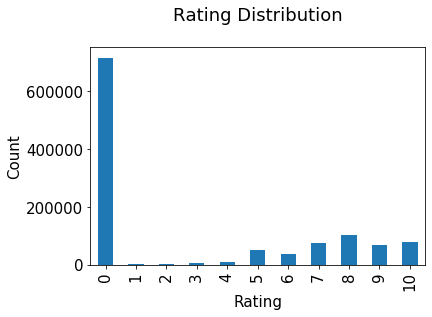

In [4]:
plt.rc("font", size=15)
ratings.bookRating.value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

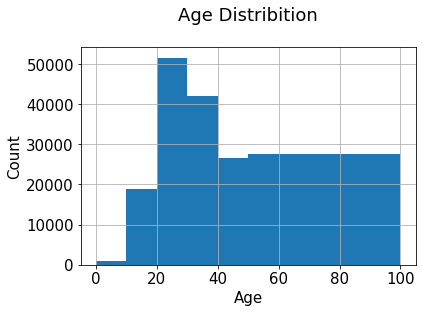

In [5]:
users.Age.hist(bins=[0,10,20,30,40,50,100])
plt.title('Age Distribition\n')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

In [6]:
#To ensure statistical significance, users with less than 200 ratings, and books with less than 100 ratings are excluded.
counts1 = ratings['userID'].value_counts()
ratings = ratings[ratings['userID'].isin(counts1[counts1 >=200].index)]
counts = ratings['bookRating'].value_counts()
ratings = ratings[ratings['bookRating'].isin(counts[counts >=100].index)]

# Collaborative Filtering Using k-Nearest Neighbors (kNN)

In [7]:
combine_book_rating = pd.merge(ratings, books, on = 'ISBN')
columns = ['yearOfPublication', 'publisher', 'bookAuthor', 'imageUrlS', 'imageUrlM', 'imageUrlL']
combine_book_rating = combine_book_rating.drop(columns, axis = 1)
combine_book_rating.head()

,userID,ISBN,bookRating,bookTitle
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...


In [8]:
combine_book_rating = combine_book_rating.dropna(axis=0,subset=['bookTitle'])
book_ratingCount = (combine_book_rating.
                   groupby(by = ['bookTitle'])['bookRating'].
                   count().
                   reset_index().
                   rename(columns = {'bookRating':'totalRatingCount'})
                    [['bookTitle','totalRatingCount']]
                   )
book_ratingCount.head()

,bookTitle,totalRatingCount
0,A Light in the Storm: The Civil War Diary of ...,2
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,Beyond IBM: Leadership Marketing and Finance ...,1
4,Clifford Visita El Hospital (Clifford El Gran...,1


In [9]:
rating_with_totalRatingCount = combine_book_rating.merge(book_ratingCount,left_on = 'bookTitle', right_on = 'bookTitle', how = 'left')
rating_with_totalRatingCount.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,82
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82


In [10]:
pd.set_option('display.float_format', lambda x: '%.3f'%x)
print(book_ratingCount['totalRatingCount'].describe())

count   160576.000
mean         3.044
std          7.428
min          1.000
25%          1.000
50%          1.000
75%          2.000
max        365.000
Name: totalRatingCount, dtype: float64


In [11]:
print(book_ratingCount['totalRatingCount'].quantile(np.arange(.9, 1, .01)))

0.900    5.000
0.910    6.000
0.920    7.000
0.930    7.000
0.940    8.000
0.950   10.000
0.960   11.000
0.970   14.000
0.980   19.000
0.990   31.000
Name: totalRatingCount, dtype: float64


In [16]:
popularity_threshold = 50
rating_popular_book = rating_with_totalRatingCount.query('totalRatingCount >=@popularity_threshold')
rating_popular_book.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,82
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82


# Filter to users in US and Canada only

In [17]:
combined = rating_popular_book.merge(users,left_on = 'userID', right_on = 'userID', how = 'left')

us_canada_user_rating = combined[combined['Location'].str.contains("usa|canada")]
us_canada_user_rating = us_canada_user_rating.drop("Age", axis = 1)
us_canada_user_rating.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount,Location
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82,"gilbert, arizona, usa"
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82,"knoxville, tennessee, usa"
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82,"byron, minnesota, usa"
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82,"cordova, tennessee, usa"
5,16795,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82,"mechanicsville, maryland, usa"


# Implementing kNN

In [18]:
from scipy.sparse import csr_matrix
us_canada_user_rating = us_canada_user_rating.drop_duplicates(['userID','bookTitle'])
us_canada_user_rating_pivot = us_canada_user_rating.pivot(index = 'bookTitle', columns = 'userID', values = 'bookRating').fillna(0)
us_canada_user_rating_matrix = csr_matrix(us_canada_user_rating_pivot.values)

In [19]:
from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(us_canada_user_rating_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [25]:
query_index = np.random.choice(us_canada_user_rating_pivot.shape[0])
print(query_index)
distances, indices = model_knn.kneighbors(us_canada_user_rating_pivot.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)

719


In [26]:
us_canada_user_rating_pivot.index[query_index]

'Welcome to the World, Baby Girl!'

In [27]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(us_canada_user_rating_pivot.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, us_canada_user_rating_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for Welcome to the World, Baby Girl!:

1: Airframe, with distance of 0.7198140421578847:
2: Sphere, with distance of 0.7365135764102495:
3: Morality for Beautiful Girls (No.1 Ladies Detective Agency), with distance of 0.7747133602270615:
4: Daisy Fay and the Miracle Man, with distance of 0.7794452919129891:
5: The Last Precinct, with distance of 0.7949090565013114:
